In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_table("quest_data/power_consumption.txt",sep=';', dtype=str, low_memory=False)

#
# **4.1 EDA and data preprocessing**

#
## *A) EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu*

In [3]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [6]:
columns_to_check = df.columns

for col in columns_to_check:
    count = df[col].str.contains(r'\?', na=False).sum()
    print(f"{col:<22}: {count}")

print(f"\n{'Columns 3-8':<22}: {df[columns_to_check[2:-1]].apply(lambda col: col.str.contains(r'\?', na=False)).all(axis=1).sum()}")

Date                  : 0
Time                  : 0
Global_active_power   : 25979
Global_reactive_power : 25979
Voltage               : 25979
Global_intensity      : 25979
Sub_metering_1        : 25979
Sub_metering_2        : 25979
Sub_metering_3        : 0

Columns 3-8           : 25979


### odstranenie otaznikov

In [7]:
df = df[~df.apply(lambda col: col.map(lambda x: '?' in str(x))).any(axis=1)]

In [8]:
df.shape

(2049280, 9)

In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### `Date` pretypovany

In [11]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

In [12]:
df.insert(0, 'DateTime', df.pop('DateTime'))
df.drop(columns=['Date', 'Time'], inplace=True)

In [13]:
for column in df.columns[1:-3]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(float)

In [14]:
for column in df.columns[-3:]:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype(int)

In [15]:
df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17


In [16]:
df.dtypes

DateTime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                    int32
Sub_metering_2                    int32
Sub_metering_3                    int32
dtype: object

In [17]:
df.describe()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-02 00:59:44.397740544,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
min,2006-12-16 17:24:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007-12-10 05:37:45,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-11-30 01:22:30,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2009-11-23 20:31:15,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,2010-11-26 21:02:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00


#### `Funkcia:` Vykreslenie KDE grafov.

In [25]:
def show_kde_graphs(df, attributes):
    num_attributes = len(attributes)

    if num_attributes == 0:
        print("No attributes to show")
        return
    
    cols = min(4, num_attributes)
    rows = math.ceil(num_attributes / cols)
    
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, column in enumerate(attributes):
        plt.subplot(rows, cols, i + 1)
        sns.kdeplot(df[column], fill=True, color='blue', alpha=0.5)
        plt.title(column)
        plt.xlabel('Hodnoty')
        plt.ylabel('Hustota')

    plt.tight_layout()
    plt.show()

#### `Funkcia` na vykreslenie box-plotov pre ukážku outlier-ov.

In [19]:
def show_box_plots(df, cols, columns):
    rows = (len(columns) + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, col in enumerate(columns):
        plt.subplot(rows, cols, i + 1)
        try:
            df[col].plot(kind='box')
            plt.title(f'{col}')
        except Exception as e:
            print(f"Chyba pri vykresľovaní boxplotu pre {col}: {e}")
        plt.ylabel('Hodnoty')

    plt.tight_layout()
    plt.show()

#
#### `Funkcia` identifikovania outlier-ov.

In [20]:
def identify_outliers(column, col_name):
    lower = column.quantile(0.25) - 1.5 * stats.iqr(column)
    upper = column.quantile(0.75) + 1.5 * stats.iqr(column)

    outliers = column[(column > upper) | (column < lower)]
    
    if not outliers.empty:
        return (col_name, outliers.count())
    else:
        return (col_name, 0)

#### `Funkcia` na vypísanie a vrátenie outlier-ov.

In [21]:
def count_outliers_and_print(df, dataframe_name):
    column_names = df.columns[3:]
    df_count = df.shape[0]

    values = []
    
    for col in column_names:
        values.append(identify_outliers(df[col], col))
    
    sorted_outliers = sorted(values, key=lambda x: x[1], reverse=True)
    
    print(f"Počet outlierov (% aj počet) pre {dataframe_name} ({df_count}):\n")
    for col, count in sorted_outliers:
        percentage = round((count / df_count) * 100, 1)
        print(f'{col:>18}  {percentage:<4}  {count:<6}')
    
    #return values

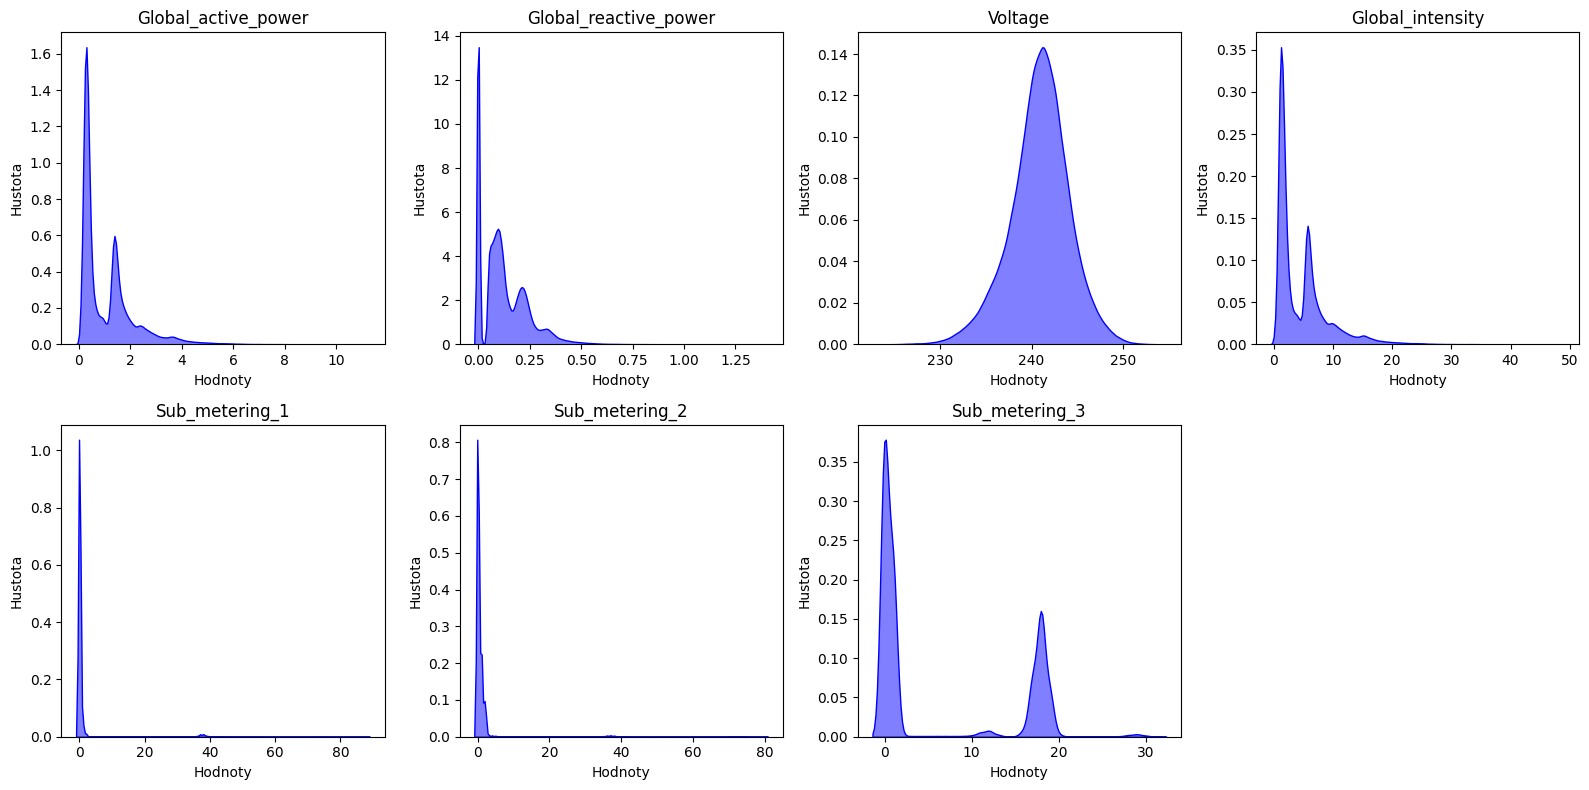

In [26]:
show_kde_graphs(df, df.columns[1:])

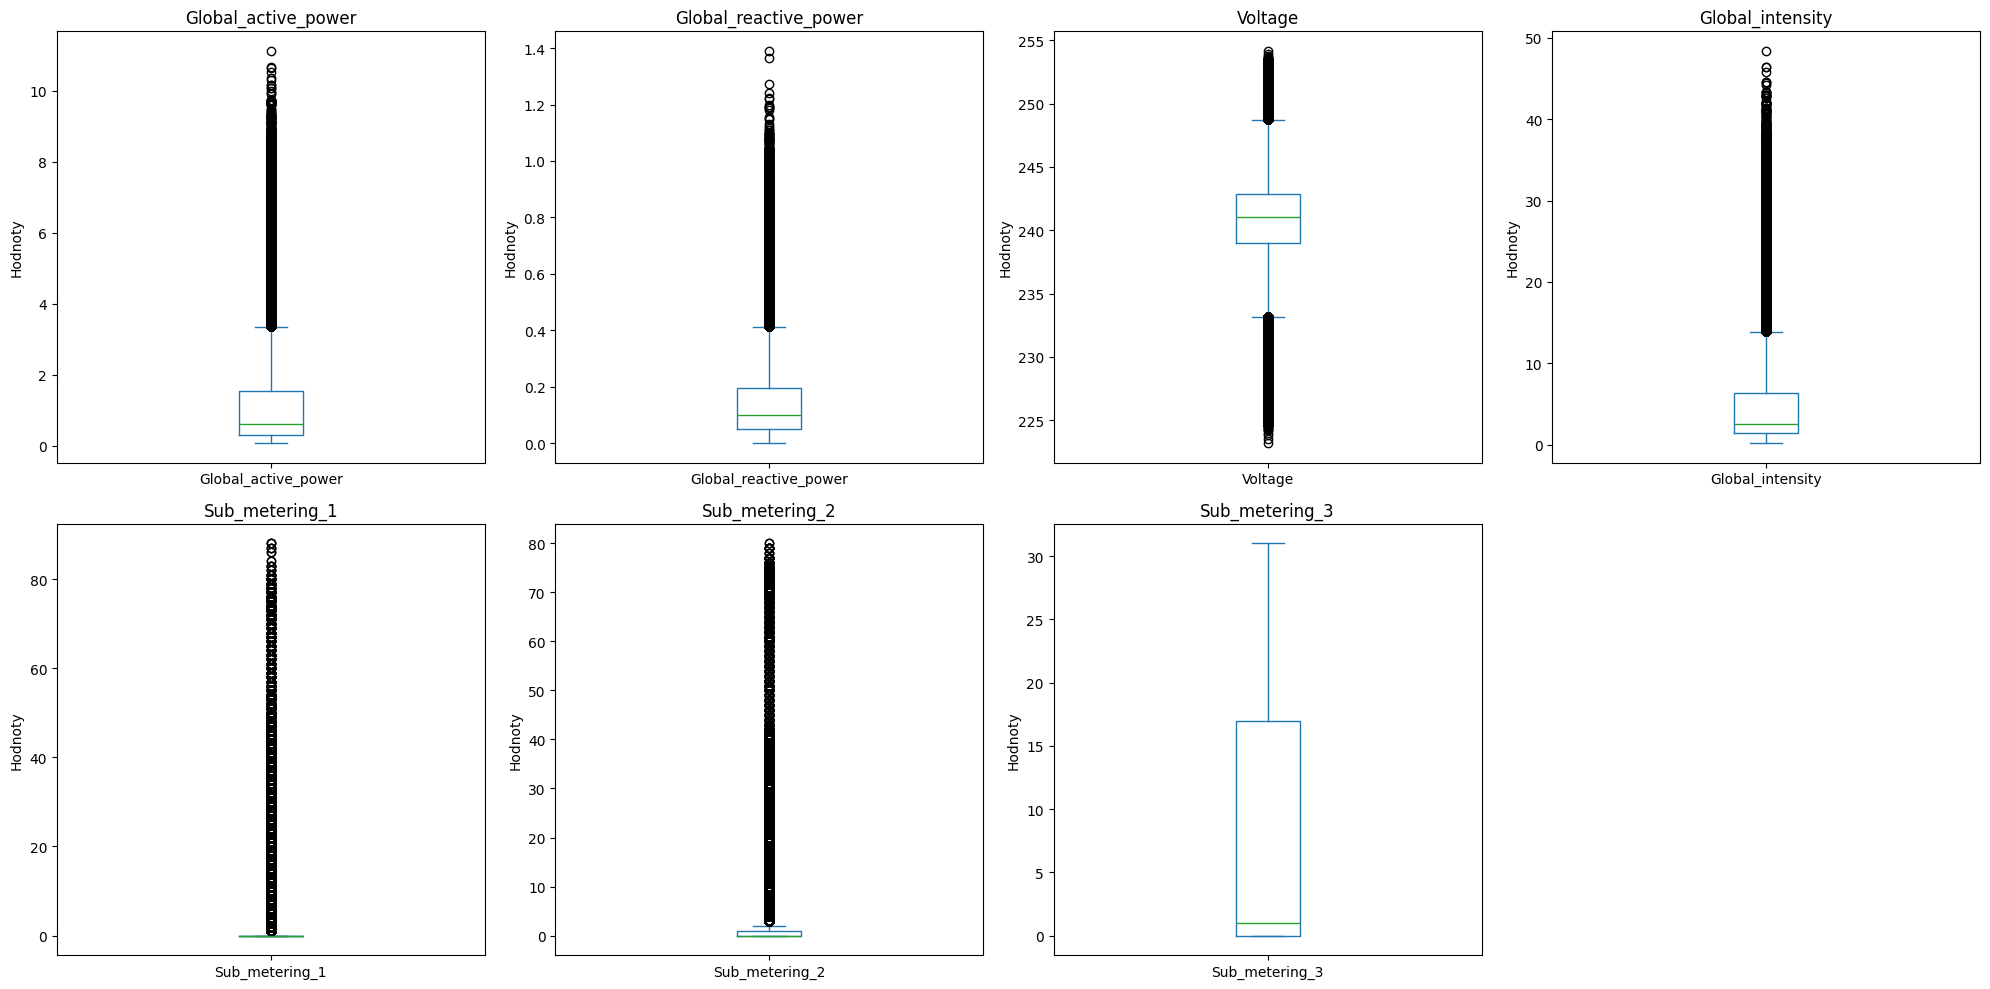

In [23]:
show_box_plots(df, 4, df.columns[1:])

In [24]:
count_outliers_and_print(df, "DF")

Počet outlierov (% aj počet) pre DF (2049280):

    Sub_metering_1  8.3   169105
  Global_intensity  4.9   100961
    Sub_metering_2  3.8   77151 
           Voltage  2.5   51067 
    Sub_metering_3  0.0   0     


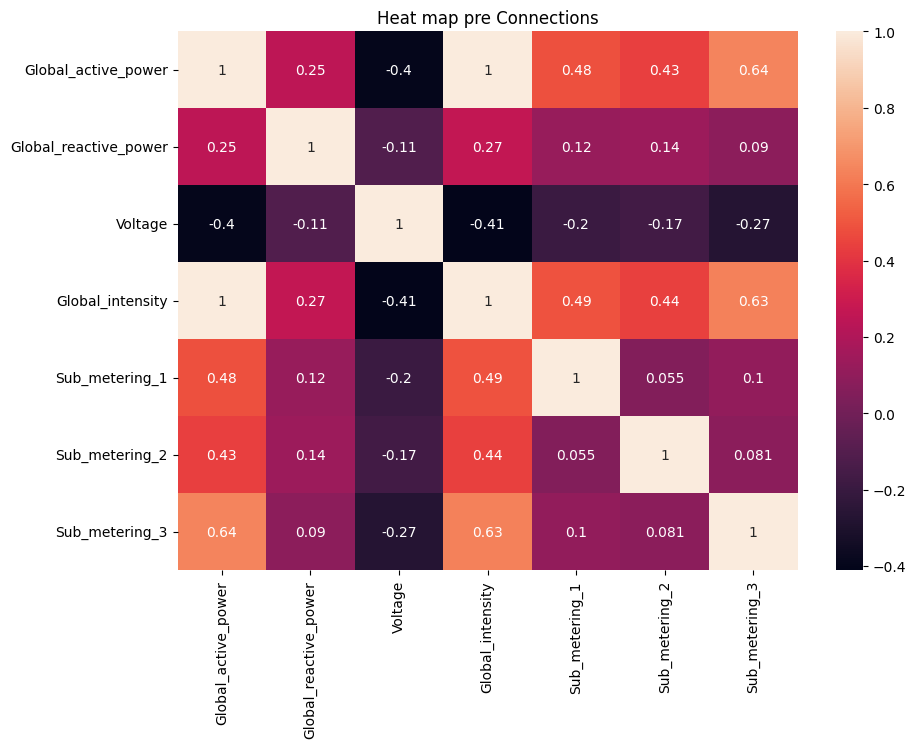

In [30]:
df_corr=df.iloc[:, 1:].corr()

fig, ax = plt.subplots(figsize=(10,7))

ax.set_title('Heat map pre Connections', fontsize=12)

sns.heatmap(df_corr, annot=True)
plt.show()

#
## *B) Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2*

#
# **4.2 Modeling and evaluation**

#
## *A) Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model*

#
## *B) Zhodnotíte Váš prístup a získaný výsledok*